# Gradient based Bayesian Optimisation with the Lotka-Volterra ODE

The standard Lotka-Volterra equation is a coupled ODE of the form

$$ \frac{d(P,Q)}{dt} = \begin{bmatrix}\alpha P - \beta PQ  \\ \delta PQ - \gamma Q \end{bmatrix}, $$

where $(P,Q)$ are the predator and prey populations and $\alpha,\beta,\gamma$ and $\delta$ are model parameters. In the following, we consider maximum-likelihood estimation of the model parameters under noisy Gaussian observations. The quantity of interest is therefore $\max_{x\in\mathcal{X}} \mathcal{L}(x)$, where $\mathcal{L}$ is the log-likelihood and data takes the form of observations of the log-likelihood and its gradient

In [2]:
import torch
from torch import nn
from torch import optim
import math

import torchdiffeq
from torchdiffeq import odeint

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np

from gaussed.distribution import SpectralGP
from gaussed.kernel.matern import MaternKernel

plt.rcParams['figure.figsize'] = [5,5]


The following cell defines a plotting function:

In [3]:
def plot_solutions(pops, times):
    plt.plot(times,pops)

## Defining the Lotka-Volterra model

The following implements the standard Lotka-Volterra model with parameters $\theta = [\alpha, \beta, \gamma, \delta]$, we assume the initial conditions are fixed.

In [4]:
class LotkaVolterra(nn.Module):
    
    def __init__(self, theta):
        super().__init__()
        self.theta = theta
    
    def forward(self, t, y):
        α,β,γ,δ = self.theta.T
        p,q = y.reshape(2,y.shape[0] // 2)
        out1 = α*p - β*p*q
        out2 = δ*p*q - γ*q
        return torch.stack([out1,out2]).flatten()
    
class LotkaVolterraModel:
    
    def __init__(self, initial, theta, variance, times):
    
        self.initial = initial
        self.theta = theta
        self.variance = variance
        self.times = times
        
        self.N = self.times.shape[0]
        
        self.error_dist = torch.distributions.Normal(0,self.variance ** 0.5)
        self.const1, self.const2 = 4e4, 1e5
        
        self.data = self.get_data()
        
    def model(self, theta, initial, times):
        true_pop = odeint(LotkaVolterra(theta), initial, times) 
        return true_pop
    
    def get_data(self):
        errors = self.error_dist.sample((self.N,2))
        out = odeint(LotkaVolterra(self.theta), self.initial, self.times) + errors
        return out
    
    def log_likelihood(self, theta):
        
        

        p0,q0 = self.initial
        initial_conditions = torch.cat([p0.repeat(theta.size(0)),q0.repeat(theta.size(0))])
    
        m = theta.size(0)
        
        #p,q = odeint(LotkaVolterra(theta), initial_conditions, self.times,method="rk4",options = {"step_size":0.05}).T.split([m,m])
        p,q = odeint(LotkaVolterra(theta), initial_conditions, self.times,rtol = 1e-8,atol=1e-8,options = {"dtype":torch.float64}).T.split([m,m]) #the default option is actually faster than rk4 with step size of 0.1
        #p,q = odeint(LotkaVolterra(theta), initial_conditions, self.times, method="dopri8", rtol = 1e-8,atol=1e-8).T.split([m,m]) #,options = {"dtype":torch.float32}
        p_data,q_data = self.data.T
        
        const = torch.Tensor([2 * math.pi * self.variance])
        
        log_probs = -self.N * torch.log(const) - 1 / (2 * self.variance) * torch.sum((p - p_data)**2 + (q - q_data)**2,dim=1)
        log_probs_a = log_probs + self.const1
        log_probs_b = log_probs_a / self.const2
    
        return log_probs_b


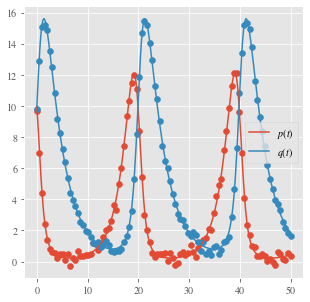

In [5]:
torch.manual_seed(1)

initial = torch.Tensor([10,10])
theta = torch.Tensor([0.5,0.1,0.3,0.1])
variance = 0.05
times = torch.linspace(0,50,100)


lotka = LotkaVolterraModel(initial,theta,variance,times)

plot_solutions(lotka.model(lotka.theta,lotka.initial,torch.linspace(0,50,300)),torch.linspace(0,50,300))

plt.scatter(lotka.times,lotka.data.T[0])
plt.scatter(lotka.times,lotka.data.T[1])
plt.legend(["$p(t)$", "$q(t)$"])

plt.show()

## Black-box targets

We define the Gaussian process over the hypercube $[0,1]^d$. 

In [6]:
def target(x):
    return lotka.log_likelihood(x)

def target_2D(x):
    true_γδ = torch.zeros(x.shape) + torch.Tensor([0.3,0.1])
    return target(torch.cat([x,true_γδ],dim=1))

## Plot 2D target

In [7]:
N_mesh = 100

x_2D = torch.linspace(0.44,0.91,N_mesh)   
y_2D = torch.linspace(0.08,0.51,N_mesh)

X_2D,Y_2D = torch.meshgrid(x_2D,y_2D)

meshs = torch.stack([X_2D,Y_2D]).T.reshape(X_2D.shape[0]**2,2)
Ztrue = target_2D(meshs)

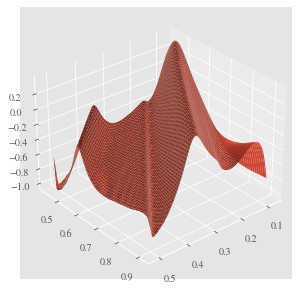

In [8]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Y_2D.numpy(),X_2D.numpy(), Ztrue.reshape(N_mesh,N_mesh).T.detach().numpy()) #-torch.mean(Z)
ax.view_init(elev=30., azim=50)
plt.show()

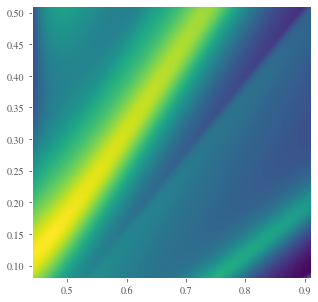

In [9]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

ax.contourf(X_2D.numpy(),Y_2D.numpy(), Ztrue.reshape(N_mesh,N_mesh).detach().numpy(),levels=100)
plt.show()

## Define black-box

The following ``lotka_volterra`` evaluates the log-likelihood as well as its gradients

In [10]:
def lotka_volterra(x):
    X = design.transform(x)
    if X.dim() == 1:
        X = X.unsqueeze(0)
    grad_x = X.clone().detach().requires_grad_(True)
    
    Y = target_2D(grad_x)
    Y.sum().backward()
    Y = Y.detach()
    Y_d1, Y_d2 = grad_x.grad.detach().T
    
    return torch.stack([Y, Y_d1, Y_d2], dim=1).flatten()


## Define GP and its transform

In [11]:
from gaussed.transforms import Differentiate
from gaussed.transforms.nonlinear import Maximise
from gaussed.solver.optimise_transform.grid_search import GridSearch

initial_parameters = [torch.Tensor([0]).requires_grad_(True), torch.Tensor([0.1]).requires_grad_(True)]
k = MaternKernel(3,2, parameters=initial_parameters)
gp = SpectralGP(k)

gp.set_domain(torch.Tensor([[0.4,0.95],[0.04,0.55]]))

gp_d1 = Differentiate(gp,[0],[1])()
gp_d2 = Differentiate(gp,[1],[1])()

NN = 40
xxx, yyy = torch.meshgrid(torch.linspace(0.45,0.9,NN),torch.linspace(0.09,0.5,NN))
mesh = torch.stack([xxx,yyy]).T.reshape(NN**2,2)
maximise_method = GridSearch(mesh)

qoi = Maximise(gp, maximise_method)()

## Define Experiment and Run

In [ ]:
from gaussed.experiment import EvaluationDesign, L2, Experiment
from gaussed.experiment.bayes_risk import BayesRiskMatheron

design = EvaluationDesign([gp, gp_d1, gp_d2])
design.set_domain(torch.Tensor([[0.45,.9],[0.09,0.5]]))

XX = torch.Tensor([[0.675, 0.295]])
design.set_initial_design(design.inverse_transform(XX))

loss = L2(qoi)
acquisition = BayesRiskMatheron(qoi, loss, design, nugget=1e-5)
experiment = Experiment(gp, lotka_volterra, design, acquisition, m=35)
experiment.start_hyp_optimising_step = 10

experiment.run(30)

## Plot Output

In [34]:
current_design = experiment.current_design
current_data = experiment.data
phi_mat = experiment.design.basis_matrix(current_design, m=35)
mean, covariance_matrix = gp.condition(phi_mat, current_data, nugget=1e-5)

mean_function = gp.get_mean(mean)

x = torch.linspace(0.44,0.91,N_mesh)  
y = torch.linspace(0.08,0.51,N_mesh)
X,Y = torch.meshgrid(x,y)

Z1 = mean_function(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(N_mesh,N_mesh).T.detach().numpy()

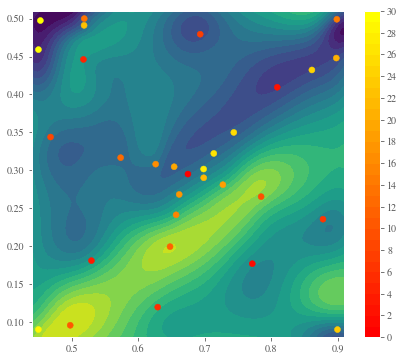

In [142]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
import numpy as np

contour = ax.contourf(X.numpy(),Y.numpy(), Z1,levels=20)
scatter = ax.scatter(design.transform(current_design).T[0],design.transform(current_design).T[1],c= torch.cat([torch.Tensor([i]) for i in range(len(design.transform(current_design)))]), cmap=plt.get_cmap("autumn",30), vmin=0, vmax=30)
fig.colorbar(scatter, ticks=np.arange(0,31,2))

plt.show()